In [1]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch

In [2]:
params_file = 'params300.csv'

In [3]:
total_qubits = 11
layers = 7
dev = qml.device("default.qubit", wires=total_qubits)

In [4]:
def brick_ansatz(params):
    """Standard Brick QCBM ."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))


@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(params):
    return brick_ansatz(params)


In [5]:
def load_params(file_path):
    params_df = pd.read_csv(file_path)
    return pnp.array(params_df.values).reshape(layers, total_qubits, 3)

params = load_params(params_file)


def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
    if len(prices) == 0:
        raise ValueError("No valid price data found in the CSV file.")
    log_returns = np.diff(np.log(prices))
    if len(log_returns) == 0:
        raise ValueError("Log returns array is empty.")
    bins = np.linspace(min(log_returns), max(log_returns), 2**total_qubits)
    return log_returns, np.digitize(log_returns, bins) - 1, bins


log_returns, training_data, bins = load_and_preprocess_data('Stoxx15_24.csv')

def generate_synthetic_log_returns(params, bins, steps=100):
    quantum_probs = quantum_model(params)
    sampled_indices = np.random.choice(len(quantum_probs), p=quantum_probs, size=steps)
    return bins[sampled_indices]


In [6]:
mjd_data = pd.read_csv('mjd_log_returns.csv')

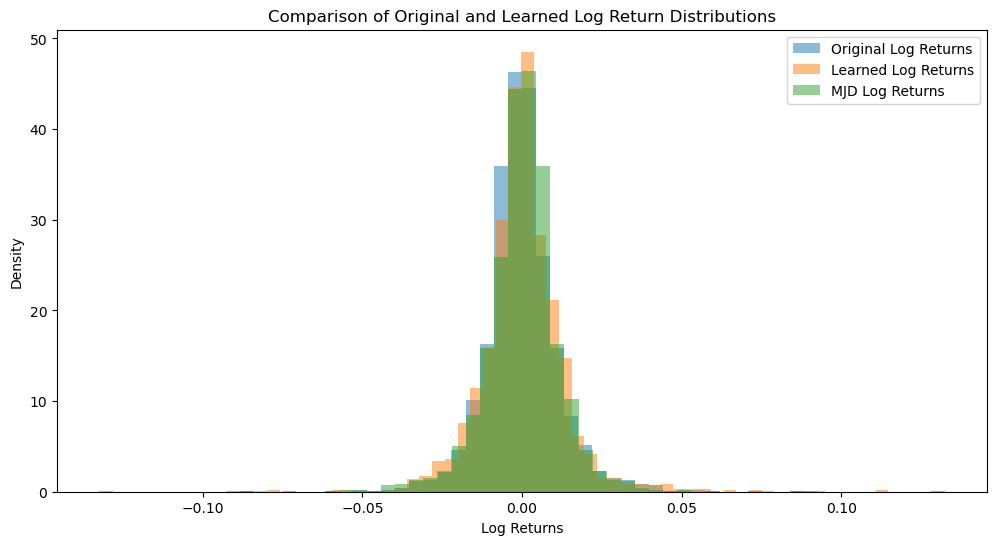

In [7]:
synthetic_log_returns = generate_synthetic_log_returns(load_params(params_file), bins, len(log_returns))

plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=50, alpha=0.5, label='Original Log Returns', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='Learned Log Returns', density=True)
plt.hist(mjd_data,bins=50,alpha=0.5,label='MJD Log Returns',density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Original and Learned Log Return Distributions')
plt.legend()
plt.show()

In [8]:
def simulate_path(params, bins, steps=100, start_value=100):
    log_returns = generate_synthetic_log_returns(params, bins, steps)
    S = np.zeros(steps)
    S[0] = 3564.63  # Starting value
    for t in range(1, steps):
        S[t] = S[t - 1] * np.exp(log_returns[t])
    return S

def propagate_process(params, bins, num_paths=10, steps=100):
    paths = []
    for _ in range(num_paths):
        path = simulate_path(params, bins, steps)
        paths.append(path)
    return np.array(paths)


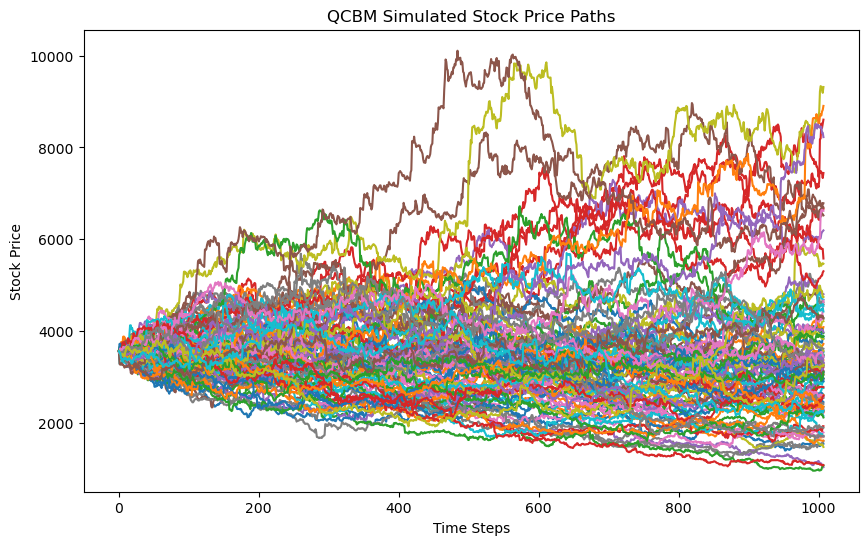

In [9]:
num_paths = 100
steps = 252*4
paths = propagate_process(params, bins, num_paths, steps)


plt.figure(figsize=(10, 6))
for i, path in enumerate(paths):
    plt.plot(path, label=f'Path {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('QCBM Simulated Stock Price Paths')
plt.show()

In [10]:
print((paths))

[[3564.63       3562.24628346 3460.31828067 ... 1537.10608953
  1543.21769854 1547.85060209]
 [3564.63       3553.80497444 3510.68466347 ... 1686.11633689
  1699.22184848 1694.60982143]
 [3564.63       3547.67840719 3543.01282218 ... 3439.97176879
  3431.37499559 3488.38407282]
 ...
 [3564.63       3558.40684207 3536.5234622  ... 3620.77131103
  3621.4730102  3616.71037722]
 [3564.63       3563.01466872 3501.98786459 ... 3233.49416309
  3234.12080863 3265.94325435]
 [3564.63       3524.0375546  3524.72050694 ... 2257.21999375
  2222.8693083  2263.4585942 ]]


In [11]:
returns = np.diff(np.log(paths), axis=1)  # Log returns for each path
losses = -returns  # Losses are negative returns
all_losses = losses.flatten()
sorted_losses = np.sort(all_losses)
var_1_percent = np.percentile(sorted_losses, 99)  # 99th percentile of losses
cvar_1_percent = np.mean(sorted_losses[sorted_losses >= var_1_percent])

qcbm_var = var_1_percent
qcbm_cvar = cvar_1_percent
print(f"1% VaR: {var_1_percent:.4f}")
print(f"1% CVaR: {cvar_1_percent:.4f}")

1% VaR: 0.0322
1% CVaR: 0.0494


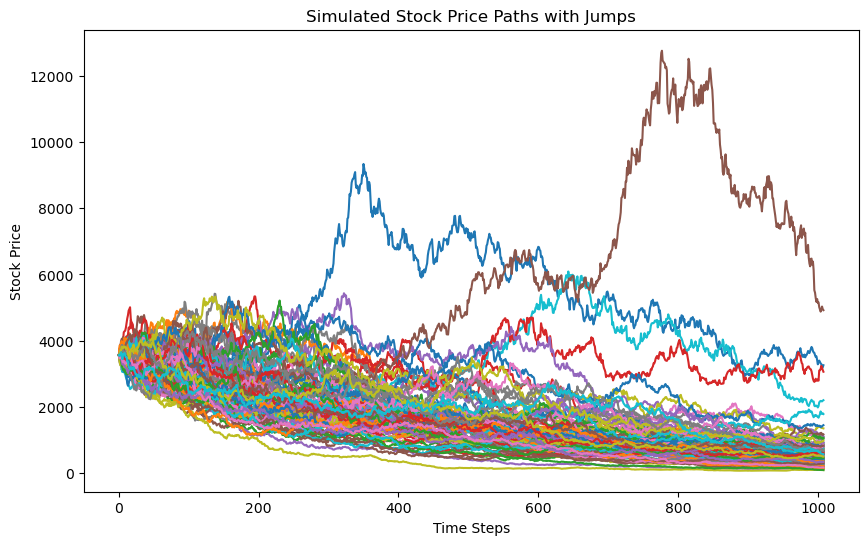

In [12]:
mu = 0.24344907  # Drift
sigma = 0.21549233  # Volatility
lam = 374.44142148  # Jump intensity (lambda)
m = -0.00201916  # Jump mean
v = 0.00024114  # Jump variance

# Simulation parameters
num_paths = 100  # Number of paths to generate
steps = 252 * 4  # Number of time steps (e.g., 4 years of daily data)
dt = 1 / 252  # Time step (assuming daily data)

# Initialize paths
paths_mjd = np.zeros((num_paths, steps + 1))  # +1 for initial price
paths_mjd[:, 0] = 3565  # Initial price (e.g., S_0 = 100)

# Generate paths
for i in range(num_paths):
    for t in range(1, steps + 1):
        # Generate the number of jumps in this time step
        num_jumps = np.random.poisson(lam * dt)
        
        # Generate jump sizes (lognormal distribution)
        jump_sizes = np.random.lognormal(mean=m, sigma=np.sqrt(v), size=num_jumps)
        total_jump = np.sum(jump_sizes - 1)  # Subtract 1 for lognormal adjustment
        
        # Generate the GBM component
        z = np.random.normal(0, 1)  # Standard normal random variable
        gbm_component = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z
        
        # Update the price
        paths_mjd[i, t] = paths_mjd[i, t - 1] * np.exp(gbm_component + total_jump)

plt.figure(figsize=(10, 6))
for i, path in enumerate(paths_mjd):
    plt.plot(path, label=f'Path {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths with Jumps')
plt.show()

In [13]:
returns = np.diff(np.log(paths), axis=1)  # Log returns for each path
losses = -returns  # Losses are negative returns
all_losses = losses.flatten()
sorted_losses = np.sort(all_losses)
var_1_percent = np.percentile(sorted_losses, 99)  # 99th percentile of losses
cvar_1_percent = np.mean(sorted_losses[sorted_losses >= var_1_percent])

mjd_var = var_1_percent
mjd_cvar = cvar_1_percent

print(f"1% VaR: {var_1_percent:.4f}")
print(f"1% CVaR: {cvar_1_percent:.4f}")

1% VaR: 0.0322
1% CVaR: 0.0494


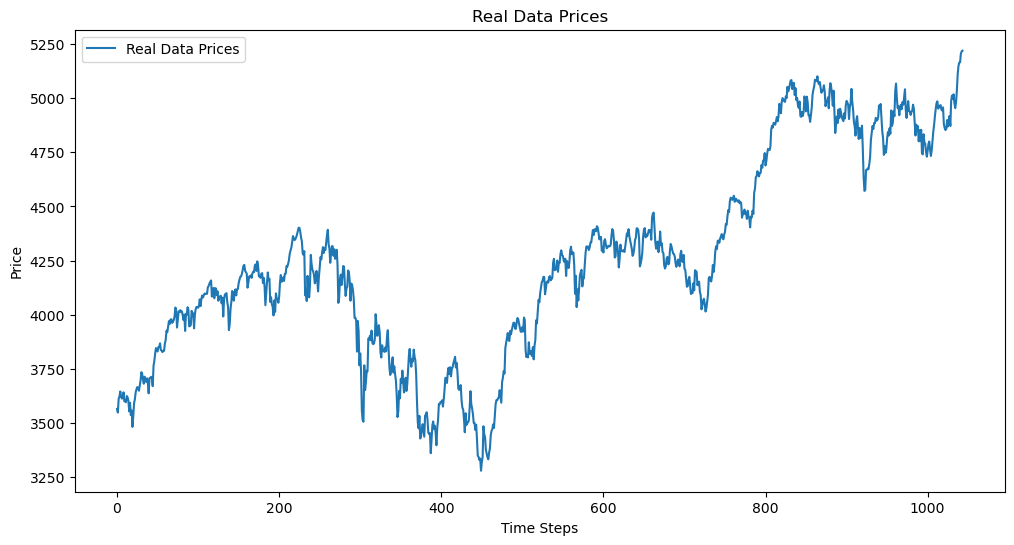

In [14]:
data = pd.read_csv('StoxxLarger.csv')
prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
prices = prices[::-1]
plt.figure(figsize=(12, 6))
plt.plot(prices, label='Real Data Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Real Data Prices')
plt.legend()
plt.show()

In [15]:
log_returns = np.diff(np.log(prices))
losses = -log_returns
var_1_percent = np.percentile(losses, 99)  # 99th percentile of losses
cvar_1_percent = np.mean(losses[losses >= var_1_percent])  # Average of losses beyond VaR

real_var = var_1_percent
real_cvar = cvar_1_percent

print(f"1% VaR: {var_1_percent:.6f}")
print(f"1% CVaR: {cvar_1_percent:.6f}")

1% VaR: 0.029907
1% CVaR: 0.037998


In [16]:
print("Real VaR:", real_var)
print("Real CVaR:", real_cvar)
print("-----------------")
print("QCBM VaR:", qcbm_var)
print("QCBM CVaR:", qcbm_cvar)
print("-----------------")
print("MJD VaR:", mjd_var)
print("MJD CVaR:", mjd_cvar)


Real VaR: 0.029906621337936184
Real CVaR: 0.03799777685241375
-----------------
QCBM VaR: 0.03215809917956847
QCBM CVaR: 0.04939861158194714
-----------------
MJD VaR: 0.03215809917956847
MJD CVaR: 0.04939861158194714


In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model


prices = prices[::-1]

2025-02-26 16:28:53.556632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740587333.572563   13671 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740587333.576978   13671 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [37]:
# Parameters
strike_price = 4000  # Example strike price
risk_free_rate = 0.05  # Annual risk-free rate
dt = 1/252  # Daily time step (assuming 252 trading days)
# Option payoff at maturity (T = steps * dt)
# Option payoff at maturity (T = steps * dt)
option_payoffs = np.maximum(paths[:, -1] - strike_price, 0)  # For call option

In [19]:
def build_hedging_network(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)  # Output: delta (hedging position)
    model = Model(inputs, outputs)
    return model

# Example: Network takes current price and time as input
model = build_hedging_network(input_shape=(2,))  # Input: [price, time]

2025-02-26 16:28:55.025404: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [27]:
def cvar_loss(y_true, y_pred, alpha=0.01):
    """
    Custom loss function to minimize CVaR of hedging errors.
    y_true: Target payoffs
    y_pred: Predicted hedge portfolio values
    """
    hedging_errors = y_true - y_pred
    var = tfp.stats.percentile(hedging_errors, 100 * (1 - alpha))
    tail_errors = tf.maximum(hedging_errors - var, 0)
    cvar = tf.reduce_mean(tail_errors) / alpha
    return cvar

def mse_loss(y_true, y_pred):
    """
    Mean Squared Error (MSE) loss function.
    """
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [35]:
def simulate_hedge(model, prices, strike_price, risk_free_rate, dt):
    portfolio_values = []
    for t in range(len(prices) - 1):
        # Input: [current price, time]
        state = np.array([[prices[t], t * dt]])
        delta = model.predict(state, verbose=0)[0][0]
        print("delta",delta)
        
        # Update portfolio value
        hedge_value = delta * (prices[t + 1] - prices[t])
        risk_free_growth = (portfolio_values[-1] if t > 0 else 0) * np.exp(risk_free_rate * dt)
        portfolio_values.append(hedge_value + risk_free_growth)
    
    return np.array(portfolio_values)

In [30]:
import tensorflow_probability as tfp

In [31]:
# Prepare training data
X_train = np.column_stack([paths[:, :-1].flatten(), np.tile(np.arange(steps - 1) * dt, num_paths)])
y_train = np.repeat(option_payoffs, steps - 1)

# Compile and train the model
model.compile(optimizer='adam', loss=mse_loss)
model.fit(
    x=X_train,
    y=y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1755950.1250
Epoch 2/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1545816.7500
Epoch 3/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1553434.8750
Epoch 4/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1534279.7500
Epoch 5/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1541085.0000
Epoch 6/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1553137.5000
Epoch 7/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1552619.6250
Epoch 8/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1532342.6250
Epoch 9/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1552049.3750
Epoch 10/10
3147/3147 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1514800.3750


In [43]:
def simulate_hedge_with_deltas(model, path, strike_price, risk_free_rate, dt):
    """
    Simulate hedge portfolio and return portfolio values and deltas.
    """
    portfolio_values = []
    deltas = []
    
    for t in range(len(path) - 1):
        # Input: [current price, time to maturity]
        state = np.array([[path[t], (len(path) - t - 1) * dt]])
        delta = model.predict(state, verbose=0)[0][0]  # Predicted delta
        deltas.append(delta)
        
        # Update portfolio value
        hedge_value = delta * (path[t + 1] - path[t])
        risk_free_growth = (portfolio_values[-1] if t > 0 else 0) * np.exp(risk_free_rate * dt)
        portfolio_values.append(hedge_value + risk_free_growth)
    
    return np.array(portfolio_values), np.array(deltas)

In [44]:
# Simulate hedge portfolio and deltas for a single path
test_portfolio, test_deltas = simulate_hedge_with_deltas(model, paths[0], strike_price, risk_free_rate, dt)

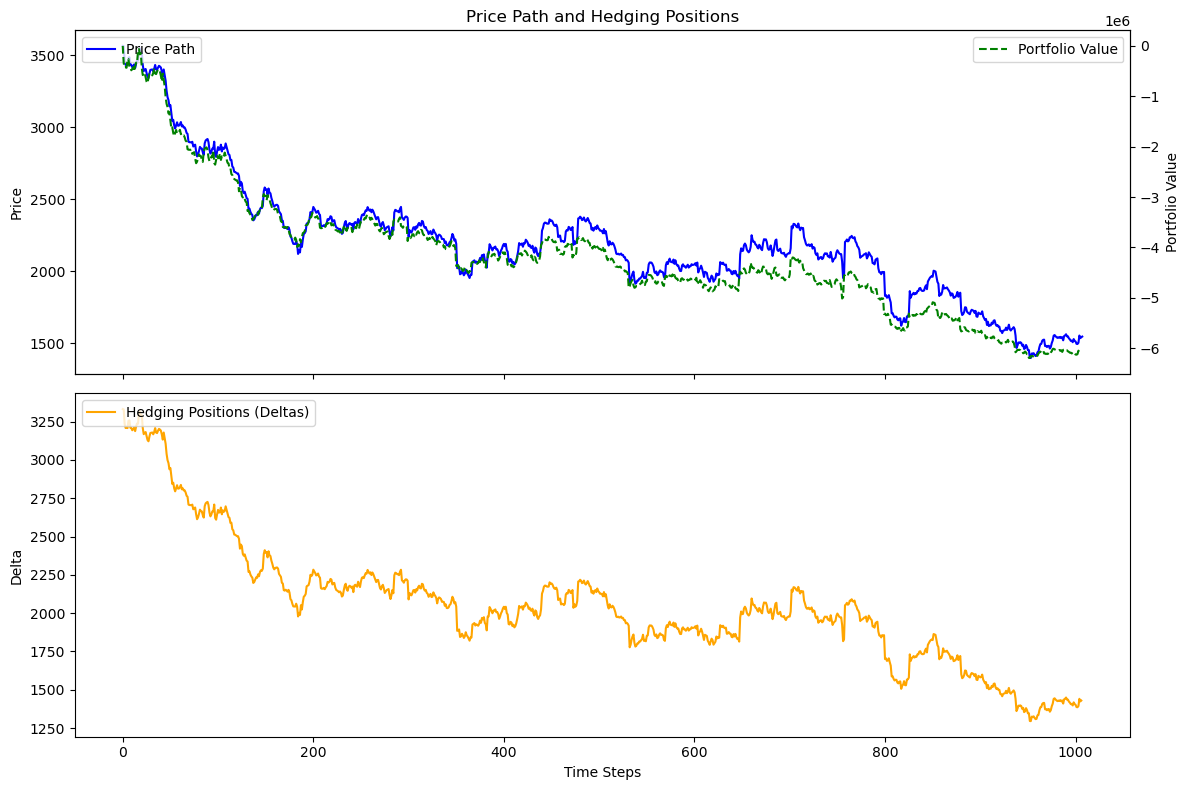

In [46]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the price path
ax1.plot(paths[0], label='Price Path', color='blue')
ax1.set_ylabel('Price')
ax1.set_title('Price Path and Hedging Positions')
ax1.legend(loc='upper left')

# Plot the hedging positions (deltas)
ax2.plot(test_deltas, label='Hedging Positions (Deltas)', color='orange')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Delta')
ax2.legend(loc='upper left')

# Plot the portfolio values on a secondary y-axis
ax1_secondary = ax1.twinx()
ax1_secondary.plot(test_portfolio, label='Portfolio Value', color='green', linestyle='--')
ax1_secondary.set_ylabel('Portfolio Value')
ax1_secondary.legend(loc='upper right')

plt.tight_layout()
plt.show()